# Мэтчинг товаров

**Задача**:
* Разработка алгоритма, который для всех товаров из `validation.csv` найдет 5 похожих из `base.csv`.

**Метрика**:
* Необходимо максимизировать метрику `accuracy@5`, которая для каждого объекта вычисляется по формуле:
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$

**Данные**:
  - __Источник:__ https://disk.yandex.ru/d/BBEphK0EHSJ5Jw
  - `base.csv` : база данных всех товаров.
    - Насчитывает 72 признака и 2918139 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
<br><br>
  - `train.csv` : обучающая выборка, взятая из `base.csv`.
    - Насчитывает 73 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
    - Признаки включают столбец с размеченными экспертами идентификаторами похожих товаров из `base.csv`
<br><br>
  - `validatation.csv` : база данных товаров, взятых из `base.csv`, для которых необходимо найти похожие.
    - Насчитывает 72 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
<br><br>

  - `validation_answer.csv` : база данных, с разметкой похожих для товаров из `validatation.csv`.
    - Насчитывает 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
<br>

**План работы**:

* Загрузка датасетов;
* Исследовательский анализ;
* Подготовка базовой модели и подбор гипер-параметров;
* Исследование влияния на целевую метрику признаков с ненормальным распределением;
* Исследование влияния на целевую метрику масштабирования признаков;
* Тестирование финальной модели.

## Импорт библиотек

In [1]:
%pip install phik -q
%pip install faiss-cpu==1.7.4 -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas  as pd
import seaborn as sb
import numpy   as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import (RobustScaler, 
                                   StandardScaler,
                                   MinMaxScaler, 
                                   MaxAbsScaler,
                                   PowerTransformer,
                                   QuantileTransformer)

from scipy.stats import kstest
from time        import perf_counter

import phik
import faiss

In [3]:
print ('faiss-cpu:',faiss.__version__)
print ('phik:',phik.__version__)

faiss-cpu: 1.7.4
phik: 0.12.4


## Установка параметров проекта

In [4]:
pd.set_option("max_columns", None)                 # show all cols
pd.set_option('max_colwidth', None)                # show full width of showing cols
pd.set_option("expand_frame_repr", False)          # print cols side by side as it's supposed to be
pd.options.display.float_format = '{:,.2f}'.format # pretty format for floats
pd.options.mode.chained_assignment = None          # ignore SettingWithCopy warning

sb.set(font_scale=0.8)                             # default font size on heatmaps was too big

## Загрузка данных

### Чтение данных

In [5]:
try:
    df_base   = pd.read_csv('datasets/base.csv', index_col=0)
    df_train  = pd.read_csv('datasets/train.csv', index_col=0)
    df_test   = pd.read_csv('datasets/validation.csv', index_col=0)
    df_answer = pd.read_csv('datasets/validation_answer.csv', index_col=0)
    print('Данные загружены из локальной папки.')
except:
    raise Exception('Ошибка при чтении данных.')

Данные загружены из локальной папки.


### Общая информация о представленном датасете

In [6]:
def show_info(data: pd.DataFrame, full: bool=True, name: str=''):
    if name != '':
        border_len = len('Имя датасета: ' + name) + 2
        print ('\n╔' + '═' * border_len + '╗')
        print (f'║ Имя датасета: {name} ║')
        print ('╚' + '═' * border_len + '╝\n')
    
    print('Первые пять строк:')
    display(data.head(5))
    if full:
        print('Описательная статистика:')
        display(data.describe())
        print('Информация по столбцам:')
        data.info()
        print("\nЧисло явных дубликатов:", data.duplicated().sum())
        print("Число пропусков:", data.isna().sum().sum())

In [7]:
show_info(df_base,full=True,name='base.csv')


╔════════════════════════╗
║ Имя датасета: base.csv ║
╚════════════════════════╝

Первые пять строк:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.08,11.15,-64.43,-118.88,216.48,-104.70,-469.07,44.35,120.92,181.45,-124.06,-32.46,-57.42,36.21,182.72,-28.07,-5.21,-1.73,-91.09,-79.47,-103.94,"1,507.23",-32.59,51.41,-51.91,813.77,-41.56,8.42,-129.98,148.77,-10.07,-143.01,79.85,-537.18,2.77,111.52,4.26,-153.34,-123.63,-39.71,-12.77,-4.17,-152.97,75.91,-57.47,17.27,-98.87,-138.07,91.00,-170.70,-50.02,59.79,78.11,-89.38,89.41,79.81,-129.51,-44.66,-80.44,5.15,-64.52,-138.78,-42.81,38.80,-151.76,-74.39,63.67,-4.70,92.93,115.27,-112.76,-60.83
1-base,-34.56,13.33,-69.79,-166.53,57.68,-86.10,-85.08,-35.64,119.72,195.23,-141.30,-126.77,-68.85,8.31,143.08,8.78,15.16,48.25,-244.95,-80.28,-81.79,429.88,-5.94,70.14,66.58,813.77,3.21,17.16,-39.42,148.16,-7.58,-174.37,101.22,-303.94,16.91,53.39,33.45,-148.55,-110.34,-33.28,-8.69,13.65,-91.23,38.45,-31.95,62.48,-166.47,-189.01,-56.73,-30.03,59.17,-56.71,63.54,-121.32,97.43,74.83,-138.78,58.89,-71.60,-251.95,11.39,-148.57,-117.77,41.10,-157.83,-94.45,68.20,24.35,179.94,116.83,-84.89,-59.52
2-base,-54.23,6.38,-29.21,-133.41,150.90,-99.44,52.55,62.38,128.95,164.38,-140.82,-22.49,-51.67,2.52,140.59,-22.04,-7.13,-5.18,-111.71,-79.03,-82.45,"1,507.23",-0.42,84.11,63.34,813.77,-105.21,18.84,-94.79,151.39,-21.48,-144.85,48.50,-780.45,64.77,79.78,-13.39,-150.06,-118.76,-40.90,-15.22,-1.86,-93.82,98.75,-46.75,65.93,-10.29,-125.32,21.05,-22.64,68.92,-54.90,66.34,-142.93,83.03,69.98,-123.73,65.32,-114.04,-529.40,-101.58,-134.66,-76.40,46.01,-207.14,127.33,65.57,66.33,81.07,116.59,"-1,074.46",-32.53
3-base,-87.52,4.04,-87.80,-185.07,76.37,-58.99,-383.18,-33.61,122.03,136.23,-108.47,-104.54,-82.39,-79.99,113.60,-39.00,-4.79,8.33,-124.86,-79.11,-107.94,"1,479.17",-125.27,24.66,-16.92,813.77,-182.68,14.72,-62.93,151.20,10.61,-134.93,58.78,-529.30,43.67,92.81,-38.94,-145.05,-124.30,-36.88,-17.74,10.54,-124.58,121.91,-17.32,105.22,-94.38,-63.77,29.22,-26.42,5.87,64.06,63.51,-112.26,80.93,72.64,-137.31,7.91,-62.19,-540.32,-89.59,-149.33,-70.65,-6.36,-147.20,-37.69,66.20,-20.57,137.21,117.47,"-1,074.46",-72.92
4-base,-72.74,6.52,43.67,-140.61,5.82,-112.07,-397.71,45.18,122.17,112.12,-110.34,-38.98,-50.23,-26.69,135.27,-7.51,8.92,111.58,-130.83,-79.32,-57.84,"1,262.92",19.23,59.81,76.16,312.70,-76.73,21.30,-24.07,167.39,-44.06,-148.13,98.04,-657.52,96.36,71.06,-36.56,-135.37,-123.71,-44.74,-10.86,8.35,-168.33,215.93,-32.98,66.86,30.84,-211.54,57.70,-67.82,-29.39,-34.12,54.71,-26.03,90.67,58.09,-134.78,77.62,-176.62,-529.76,-100.57,-125.32,-57.20,56.64,-159.35,85.94,66.77,-2.51,65.32,135.05,"-1,074.46",0.32


Описательная статистика:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,"2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00","2,918,139.00"
mean,-86.23,8.08,-44.58,-146.63,111.32,-71.99,-392.22,20.35,123.68,124.46,-143.14,-69.89,-41.26,7.59,148.99,-23.17,-0.94,-19.31,-137.27,-79.19,-98.25,"1,257.53",-6.82,56.67,26.70,727.10,-66.25,16.32,-86.37,151.73,-11.61,-144.23,87.22,-554.16,36.24,75.20,-16.49,-146.64,-118.51,-41.88,-9.48,4.05,-112.74,120.87,-39.81,58.94,-84.89,-138.47,47.93,-32.38,26.58,-21.72,67.00,-117.90,88.03,69.20,-132.91,13.23,-119.60,-316.09,-64.94,-130.67,-79.02,33.30,-154.80,14.15,67.79,23.54,74.96,115.57,-799.34,-47.79
std,24.89,4.95,38.63,19.84,46.35,28.19,271.65,64.22,6.36,64.43,41.69,51.22,38.96,36.60,33.64,13.08,20.83,52.97,46.63,0.76,28.16,399.96,51.97,34.36,38.94,205.57,61.53,4.66,48.51,10.09,28.95,34.76,27.86,260.65,39.90,21.45,25.85,9.95,13.14,19.20,8.19,5.84,56.94,46.72,14.74,32.11,63.19,57.74,45.20,58.29,58.95,51.74,13.07,54.71,4.77,11.95,7.82,51.08,55.24,210.66,62.48,9.57,30.46,28.89,41.23,98.95,1.82,55.34,61.35,21.18,385.41,41.75
min,-199.47,-13.91,-240.07,-232.67,-105.58,-211.01,-791.47,-301.86,93.15,-173.87,-343.84,-368.45,-226.09,-175.62,-15.27,-85.92,-96.37,-272.57,-351.75,-83.15,-243.73,136.82,-238.29,-88.18,-143.18,-61.98,-358.55,-8.36,-314.01,107.44,-156.73,-298.68,-34.65,"-1,045.31",-137.85,-21.52,-137.99,-195.42,-176.91,-132.71,-47.58,-21.58,-338.12,-87.71,-63.10,-77.25,-362.93,-418.70,-145.39,-322.81,-280.27,-264.63,6.20,-381.26,65.58,14.08,-167.06,-196.18,-359.71,-681.04,-400.79,-171.35,-220.57,-88.51,-353.90,-157.59,59.51,-233.14,-203.60,15.72,"-1,297.93",-226.78
25%,-103.07,4.71,-69.56,-159.91,80.51,-91.38,-629.33,-22.22,119.48,81.77,-170.32,-104.03,-66.63,-16.94,125.97,-31.77,-15.15,-55.46,-167.59,-79.68,-116.84,"1,088.60",-42.24,33.30,0.56,813.77,-107.85,13.26,-118.66,144.89,-30.75,-167.04,68.30,-771.30,9.35,60.91,-34.14,-153.27,-127.45,-54.79,-14.98,0.04,-151.59,88.20,-52.87,36.99,-128.20,-176.60,17.90,-69.95,-12.33,-56.28,58.46,-154.49,84.71,61.31,-138.10,-22.39,-157.43,-498.48,-106.55,-137.39,-98.76,16.99,-180.78,-71.30,66.58,-12.52,33.78,101.69,"-1,074.46",-75.67
50%,-86.23,8.04,-43.82,-146.78,111.87,-71.92,-422.20,20.80,123.89,123.50,-141.72,-70.23,-40.40,8.13,149.31,-22.91,-1.03,-19.80,-136.80,-79.18,-97.53,"1,507.23",-6.42,57.00,27.13,813.77,-66.20,16.39,-85.54,151.64,-11.19,-144.12,86.87,-529.30,35.32,74.61,-16.32,-146.72,-118.60,-42.03,-9.47,4.05,-113.06,119.90,-40.03,58.96,-85.11,-137.38,46.97,-29.17,27.51,-22.21,67.22,-117.63,88.01,69.36,-132.83,13.11,-120.46,-315.99,-63.69,-130.88,-78.49,34.72,-153.98,13.83,67.81,23.42,74.93,116.02,"-1,074.46",-48.59
75%,-69.26,11.47,-19.63,-133.33,142.37,-52.44,-156.67,63.92,127.97,167.22,-114.99,-35.70,-14.84,32.67,172.16,-14.34,13.37,16.59,-107.54,-78.68,-79.24,"1,507.23",28.23,79.66,53.09,813.77,-25.58,19.

Информация по столбцам:
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float

In [8]:
show_info(df_train,full=True,name='train.csv')


╔═════════════════════════╗
║ Имя датасета: train.csv ║
╚═════════════════════════╝

Первые пять строк:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.88,17.97,-42.12,-183.94,187.52,-87.14,-347.36,38.31,109.09,30.41,-88.08,-52.70,-27.69,4.87,198.35,-30.08,-3.80,-135.81,-161.84,-78.51,-94.43,898.44,-70.14,78.42,108.03,813.77,-74.79,12.61,-183.82,149.72,-27.04,-133.21,106.42,-303.94,48.73,58.19,24.25,-151.22,-104.28,-34.49,-12.59,2.62,-120.97,149.99,-31.95,82.31,-115.83,-243.31,6.62,-132.20,68.71,-38.81,62.94,-132.65,89.19,87.04,-121.28,-6.99,-206.51,29.49,-77.03,-132.39,-105.43,70.11,-155.80,-101.97,65.90,34.46,62.64,134.76,-415.75,-25.96,675816-base
1-query,-87.78,6.81,-32.05,-177.26,120.80,-83.81,-94.57,-78.43,124.92,140.33,-177.61,-85.00,42.81,-57.26,96.79,-19.26,0.74,50.62,-155.27,-78.66,-92.76,353.16,-34.74,82.49,-28.45,813.77,-137.53,26.60,-136.78,153.36,48.81,-115.92,87.46,-222.29,25.12,91.89,-30.64,-136.59,-140.50,-43.45,-7.23,8.27,-117.92,149.15,-18.75,95.32,-60.09,-83.82,37.45,-23.30,74.06,-7.14,75.86,-112.05,82.86,54.07,-134.01,-26.14,-214.63,-457.85,21.46,-137.41,-40.81,4.67,-151.70,-1.64,68.17,25.10,89.97,130.59,"-1,035.09",-51.28,366656-base
2-query,-49.98,3.84,-116.12,-180.40,190.13,-50.84,26.94,-30.45,125.77,211.61,-86.35,-35.67,16.40,-80.80,137.91,-23.53,-47.26,-16.65,-194.51,-78.37,-69.32,"1,507.23",-52.50,-34.17,52.96,813.77,-18.02,20.95,-50.32,158.76,0.18,-183.07,99.05,"-1,018.47",-51.80,97.77,-10.87,-144.42,-133.82,-78.90,-17.20,4.47,-63.97,154.64,-30.21,48.53,-122.41,-112.71,53.46,-31.12,107.84,16.48,77.93,-95.62,91.46,63.12,-126.94,8.07,-195.68,-163.12,-72.83,-139.22,-52.03,78.04,-169.15,82.14,66.01,18.40,212.41,121.93,"-1,074.46",-22.55,1447819-base
3-query,-47.81,9.09,-115.40,-121.01,94.65,-109.26,-775.15,79.19,124.00,242.65,-146.52,-159.47,-13.84,-6.11,118.94,-44.59,9.56,14.44,-156.91,-78.79,-78.74,"1,507.23",19.96,34.83,-8.82,813.77,-125.61,17.58,-58.45,141.28,-54.96,-136.99,63.88,"-1,018.47",89.23,65.92,-24.08,-152.33,-91.20,-28.23,-4.77,0.16,-129.13,122.96,-30.80,123.62,-37.54,-72.14,71.24,-168.12,118.24,-18.07,37.26,-137.69,87.50,62.44,-131.26,35.69,-86.04,-379.34,-153.47,-131.20,-61.57,44.52,-145.42,93.99,64.13,106.06,83.18,118.28,"-1,074.46",-19.90,1472602-base
4-query,-79.63,14.44,-58.90,-147.05,57.13,-16.24,-321.32,45.98,125.94,103.39,-107.15,-8.80,-50.98,29.46,143.39,5.61,-45.27,9.64,-77.55,-79.07,-77.93,"1,507.23",16.61,116.28,33.75,813.77,-105.77,6.52,-19.81,157.69,-20.60,-146.59,78.85,-780.45,87.56,73.04,16.89,-144.66,-116.12,-19.35,-7.71,-5.39,-140.25,193.18,-53.15,79.87,-151.13,-45.06,79.80,46.76,47.68,-24.10,75.14,-207.35,93.44,51.51,-135.48,99.80,-49.16,-203.21,-127.75,-103.34,-68.77,45.03,-196.09,-117.63,66.93,42.46,77.62,92.48,"-1,074.46",-21.15,717819-base


Описательная статистика:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,"100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00"
mean,-85.33,7.66,-43.67,-146.12,111.77,-73.18,-440.62,21.23,123.07,126.12,-141.17,-69.23,-42.56,6.51,149.08,-23.94,-2.22,-12.96,-138.71,-79.16,-97.47,"1,297.27",-3.60,55.91,23.47,742.79,-64.97,16.37,-86.20,152.10,-13.66,-144.51,89.75,-587.55,36.47,73.11,-13.87,-146.49,-118.34,-41.13,-9.26,4.14,-104.93,122.24,-40.32,59.05,-84.05,-140.79,46.14,-34.14,29.46,-22.34,67.58,-120.05,88.19,69.54,-132.34,14.45,-120.30,-315.28,-66.38,-130.67,-81.15,36.90,-152.22,14.00,67.80,23.03,73.41,115.19,-709.76,-48.51
std,25.80,4.96,39.11,20.43,47.70,28.72,279.02,65.99,6.49,64.91,41.61,51.26,40.82,37.59,34.17,13.02,20.98,55.21,48.74,0.78,28.38,375.12,50.06,35.62,40.80,191.05,63.16,4.83,49.51,10.39,29.19,35.82,28.31,273.29,39.76,20.01,25.82,10.38,13.58,19.87,8.30,5.92,56.52,48.11,14.74,31.09,66.06,59.85,46.33,59.33,60.93,54.99,12.99,55.92,4.82,12.34,7.95,49.23,55.73,210.66,64.91,9.41,30.68,25.36,41.02,99.08,1.84,55.47,62.20,21.58,405.96,41.22
min,-186.28,-11.56,-224.90,-223.31,-93.27,-184.96,-791.47,-278.58,94.83,-142.16,-330.57,-352.41,-214.74,-145.86,8.82,-82.65,-91.66,-247.59,-326.65,-82.64,-228.81,136.87,-211.97,-87.32,-122.58,-61.80,-338.56,-6.63,-285.67,111.39,-130.44,-290.12,-25.55,"-1,044.14",-119.90,-11.93,-124.56,-193.92,-166.08,-123.06,-43.06,-18.98,-324.94,-67.54,-63.10,-64.79,-327.32,-365.06,-129.88,-280.37,-250.34,-236.15,18.48,-354.92,66.07,18.10,-161.19,-183.85,-330.64,-681.03,-358.46,-169.57,-210.06,-60.78,-317.83,-157.59,60.67,-203.75,-181.97,22.60,"-1,297.87",-209.94
25%,-103.31,4.31,-69.49,-160.03,79.47,-92.83,-738.54,-22.13,118.67,82.55,-168.60,-103.05,-69.80,-18.82,126.37,-32.38,-16.46,-49.61,-171.66,-79.66,-115.41,"1,248.13",-37.05,31.44,-5.05,813.77,-106.86,13.19,-119.61,145.14,-32.81,-168.54,70.43,-803.39,9.51,59.98,-30.93,-153.34,-127.60,-54.59,-14.77,0.09,-144.02,89.14,-53.81,37.83,-129.67,-181.18,14.32,-73.42,-11.03,-59.61,58.55,-157.93,84.91,61.21,-137.75,-19.54,-158.72,-497.15,-110.07,-137.07,-101.50,19.77,-178.93,-71.75,66.56,-14.14,31.69,100.59,"-1,074.46",-76.48
50%,-85.27,7.65,-42.83,-146.07,112.26,-73.36,-511.84,22.28,123.09,125.96,-140.46,-68.75,-41.92,6.74,149.71,-23.71,-2.34,-12.19,-139.01,-79.14,-96.86,"1,507.23",-3.61,55.27,23.31,813.77,-65.23,16.47,-86.51,151.99,-13.22,-144.58,89.97,-579.59,36.40,73.12,-13.40,-146.42,-118.36,-41.35,-9.21,4.21,-106.11,122.34,-39.95,59.34,-85.37,-140.50,45.50,-31.94,30.27,-23.29,67.26,-120.10,88.19,69.66,-132.26,13.61,-120.23,-315.18,-65.25,-130.80,-80.86,36.71,-151.58,14.07,67.81,23.44,72.88,115.24,-808.80,-48.70
75%,-67.33,10.98,-17.71,-132.28,143.76,-53.70,-201.12,65.90,127.54,169.70,-113.14,-34.67,-14.63,32.07,172.63,-15.44,11.70,24.46,-106.75,-78.64,-78.58,"1,507.23",29.47,79.56,51.79,813.77,-22.89,19.66,-53.06,158.89,5.98,-120.44,109.22,-349.55,63.63,86.28,3.64,-139.45,-109.07,-27.69,-3.67,8.25,-66.75,154.74,-26.76,80.60,-39.21,-100.56,77.58,6.8

Информация по столбцам:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non

In [9]:
show_info(df_test,full=True,name='validation.csv')


╔══════════════════════════════╗
║ Имя датасета: validation.csv ║
╚══════════════════════════════╝

Первые пять строк:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.37,3.60,-13.21,-125.93,110.75,-81.28,-461.00,139.82,112.88,75.22,-131.89,-140.97,-57.99,-22.87,150.90,7.97,17.62,-34.87,-216.14,-80.91,-52.58,263.36,56.27,66.92,21.61,813.77,-32.78,20.79,-79.78,156.31,-42.83,-71.72,83.28,-304.17,1.61,55.83,-29.47,-139.16,-126.04,-62.64,-5.01,11.98,-43.08,190.12,-25.00,76.15,-245.26,-143.66,-4.26,-46.66,-27.09,-34.35,75.53,-47.17,92.70,60.48,-127.49,-39.48,-124.38,-307.95,45.51,-144.19,-75.51,52.83,-143.44,59.05,69.28,61.93,111.59,115.14,"-1,099.13",-117.08
100001-query,-53.76,12.79,-43.27,-134.42,114.45,-90.52,-759.63,64.00,127.12,53.13,-153.72,-63.95,-52.37,-33.39,148.62,-22.48,15.16,-56.20,-153.61,-79.83,-101.06,"1,203.54",81.60,101.02,56.78,92.21,-126.86,10.38,-38.52,165.38,-77.84,-169.54,103.48,-915.74,16.11,14.67,-38.71,-149.54,-138.79,-36.08,-2.78,2.28,-142.48,189.95,-18.41,90.52,-95.53,-259.64,52.44,-30.00,14.50,-1.07,66.84,-161.28,94.79,50.42,-125.08,-25.17,-176.18,-655.84,-99.24,-141.54,-79.44,29.19,-168.61,-82.87,70.77,-65.98,97.08,123.39,-744.44,-25.01
100002-query,-64.18,-3.98,-7.68,-170.16,96.45,-62.38,-759.63,87.48,131.27,168.92,-220.31,-31.38,-8.79,2.29,133.27,-41.31,14.31,-18.23,-205.53,-78.16,-96.61,"1,507.23",-5.96,34.94,-56.09,813.77,-13.20,18.97,-35.11,151.37,-17.49,-145.88,15.53,-655.40,39.41,62.55,9.92,-143.93,-123.11,-37.03,-13.50,12.91,-116.04,176.28,-45.91,103.49,-90.66,-162.62,117.13,13.08,69.83,-6.87,63.71,-123.85,91.61,59.76,-129.57,-12.82,-154.20,-407.20,5.52,-126.81,-134.80,37.37,-159.66,-119.23,67.71,86.00,137.64,141.08,-294.05,-70.97
100003-query,-99.29,16.12,9.84,-148.06,83.70,-133.73,58.58,-19.05,115.04,75.21,-114.27,-71.41,-65.35,24.38,50.47,-14.72,15.07,-46.68,-176.60,-78.69,-139.23,325.55,3.63,74.93,-4.80,813.77,-52.98,15.64,-54.09,151.31,21.09,-134.51,65.12,-529.30,131.57,67.64,-22.88,-145.91,-86.92,-11.86,-22.19,0.46,-212.53,170.52,-48.09,99.71,-194.69,-141.52,60.22,73.39,118.57,58.90,55.57,-181.09,83.34,66.08,-114.05,-57.16,-56.34,-318.68,-15.98,-128.10,-77.24,44.10,-132.53,-106.32,70.88,23.58,133.18,143.25,-799.36,-89.39
100004-query,-79.53,-0.36,-16.03,-170.88,165.45,-28.29,33.93,34.41,128.90,102.09,-76.21,-26.39,34.42,50.94,157.68,-23.79,-33.18,-0.59,-193.32,-79.65,-91.89,"1,358.48",44.03,121.53,46.18,433.62,-82.23,21.07,-32.94,149.27,0.40,-97.67,81.72,-825.64,9.40,49.36,17.73,-160.17,-129.37,-55.53,-2.60,-0.23,-41.37,92.09,-58.63,73.66,-10.26,-175.66,25.40,47.87,51.46,140.95,58.75,-215.49,91.26,44.17,-135.30,-19.51,-106.67,-127.98,-11.43,-135.57,-123.77,45.64,-134.26,13.74,70.62,15.33,154.57,101.70,"-1,171.89",-125.31


Описательная статистика:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,"100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00"
mean,-85.30,7.67,-43.84,-146.12,111.64,-73.27,-441.40,21.59,123.08,126.00,-141.22,-69.34,-42.63,6.27,149.01,-23.96,-2.01,-13.15,-138.54,-79.16,-97.36,"1,301.40",-3.44,56.10,23.36,741.16,-64.99,16.37,-86.14,152.08,-13.48,-144.57,89.71,-588.60,36.55,73.09,-13.89,-146.46,-118.39,-40.99,-9.19,4.16,-104.78,122.10,-40.31,59.12,-83.62,-141.00,46.19,-34.15,29.40,-22.54,67.49,-120.31,88.17,69.50,-132.38,14.41,-120.38,-316.40,-66.61,-130.65,-81.13,36.78,-152.34,14.40,67.79,23.25,73.11,115.20,-709.46,-48.42
std,25.78,4.96,39.14,20.50,47.75,28.52,279.24,66.48,6.50,64.98,41.57,51.48,40.86,37.85,34.03,13.01,20.99,55.34,48.79,0.78,28.50,371.54,50.29,35.60,40.85,193.20,63.27,4.85,49.51,10.41,29.28,35.91,28.43,273.79,39.61,20.04,25.80,10.39,13.60,19.85,8.36,5.91,56.99,48.13,14.75,31.13,65.93,59.60,46.00,59.61,60.94,55.14,13.04,56.11,4.81,12.32,7.89,49.39,55.82,211.13,65.20,9.43,30.69,25.43,41.25,98.70,1.84,55.40,62.06,21.49,405.67,41.29
min,-190.35,-11.11,-217.54,-220.05,-81.20,-176.71,-791.46,-265.61,96.22,-135.67,-321.54,-363.49,-204.30,-144.10,-14.82,-78.60,-86.84,-272.57,-329.86,-82.67,-231.38,136.85,-208.90,-84.22,-138.22,-61.88,-341.96,-6.66,-282.25,110.36,-150.15,-281.12,-24.08,"-1,044.14",-117.47,-17.64,-124.31,-194.13,-166.12,-126.34,-43.32,-19.32,-326.30,-79.30,-63.10,-76.79,-365.28,-375.45,-121.27,-277.38,-279.89,-234.52,12.40,-381.61,65.99,17.30,-162.87,-156.58,-329.70,-681.04,-339.97,-168.74,-215.15,-66.27,-337.63,-157.59,60.38,-210.67,-175.92,25.27,"-1,297.92",-209.94
25%,-103.23,4.29,-69.68,-160.21,79.10,-92.79,-740.62,-21.80,118.66,82.31,-168.56,-103.34,-70.15,-19.09,126.44,-32.36,-16.39,-49.94,-171.70,-79.67,-115.39,"1,248.13",-36.89,31.74,-5.27,813.77,-107.34,13.18,-119.53,145.13,-32.82,-168.73,70.17,-803.39,9.70,59.97,-30.79,-153.33,-127.66,-54.46,-14.76,0.11,-143.90,89.15,-53.81,37.65,-129.17,-180.88,14.92,-73.76,-10.88,-59.95,58.41,-158.22,84.89,61.30,-137.75,-20.10,-158.85,-499.83,-110.39,-137.09,-101.69,19.56,-179.12,-70.42,66.55,-13.86,31.49,100.54,"-1,074.46",-76.36
50%,-85.30,7.66,-43.23,-146.08,111.96,-73.58,-513.92,22.14,123.06,126.08,-140.41,-68.62,-42.19,6.42,149.64,-23.76,-2.08,-12.40,-139.00,-79.14,-96.69,"1,507.23",-3.39,55.46,23.12,813.77,-65.25,16.50,-86.37,151.96,-13.16,-144.63,89.94,-579.59,36.47,72.99,-13.34,-146.36,-118.38,-41.19,-9.16,4.22,-105.76,121.81,-39.87,59.46,-84.96,-140.93,45.58,-32.08,30.38,-23.20,67.17,-120.33,88.15,69.59,-132.32,13.51,-120.46,-317.22,-65.76,-130.75,-81.03,36.41,-151.43,14.77,67.80,23.51,72.15,115.28,-807.03,-48.67
75%,-67.42,10.99,-17.77,-132.12,143.90,-53.86,-202.57,66.10,127.54,169.68,-113.32,-34.84,-14.72,31.93,172.42,-15.46,11.97,24.23,-106.61,-78.64,-78.38,"1,507.23",29.88,79.82,51.82,813.77,-22.85,19.69,-52.95,158.92,6.25,-120.42,109.51,-350.78,63.61,86.36,3.82,-139.43,-109.20,-27.54,-3.59,8.25,-66.32,154.69,-26.63,81.01,-39.19,-101.45,77.26,7

Информация по столбцам:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      1000

In [10]:
show_info(df_answer,full=True,name='validation_answer.csv')


╔═════════════════════════════════════╗
║ Имя датасета: validation_answer.csv ║
╚═════════════════════════════════════╝

Первые пять строк:


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Описательная статистика:


,Expected
count,100000
unique,91502
top,210304-base
freq,7


Информация по столбцам:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB

Число явных дубликатов: 8498
Число пропусков: 0


### Выводы по разделу

**Размер датасетов**:
  - `df_base`: 2918139 x 72 с идентификаторами объектов в индексе;
  - `df_train`: 100000 x 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `df_test`: 100000 x 72 с идентификаторами объектов в индексе;
  - `df_answer`: 100000 x 1 - признак ответов с идентификаторами объектов в индексе.

**Пропуски и дубликаты**:
  - Данные не имеют пропусков и дубликатов за исключением дубликатов списка ответов валидационной выборки `df_answer`, которые означают, что одному товару могут соответствовать несколько.
<br><br>

## Предобработка и исследовательский анализ

### Вспомогательные функции

In [11]:
def sample_kstest(x, y = None, frac=None):
    '''
    Calculalates the representative sample percentage by conducting
    Kolmogorov-Smirnov test for two dataframes or tests two distributions for
    equality.
    Arguments:
    - x: dataframe/series/array.
    - y: series/array.
    '''

    if (isinstance(x, pd.DataFrame) and not y and isinstance(frac, (list, np.ndarray))):
        fracs = frac
        np.random.seed(42)

        for frac in fracs:
            i = 0
            y = x.sample(frac=frac, random_state=42)
            for col in x.columns:
                _, p_value = kstest(x[col], y[col])
                if p_value < .05:
                    break
                else:
                    i += 1
                if i == len(x.columns):
                    print('Распределения признаков в выборках одинаковы при'+
                    f' выборке {frac:.0%} объектов.')
                    return
        print('Найти репрезентативный процент выборки не удалось.')
    else:
        _, p_value = kstest(x, y)
        if p_value < .05:
            print(f'Распределение признаков различны.')
        else:
            print(f'Распределение признаков одинаковы.')

### Распределение признаков в выборке `base`

* Т.к. датафреймы `df_train` и `df_test` являются подвыборками `df_base`, ограничимся выводом графиков для этого датафрейма.

* Т.к. `df_base` содержит большое кол-во объектов, для построения гистограмм и диаграмм размаха вызовем соответствующую функцию и найдём процент выборки, при котором подвыборка будет репрезентативна.

In [12]:
sample_kstest(x=df_base, frac=np.linspace(.1, .9, 8))

Распределения признаков в выборках одинаковы при выборке 10% объектов.


In [13]:
df_base_short = df_base.sample(frac=0.25, random_state=1)
df_base_short.shape

(729535, 72)

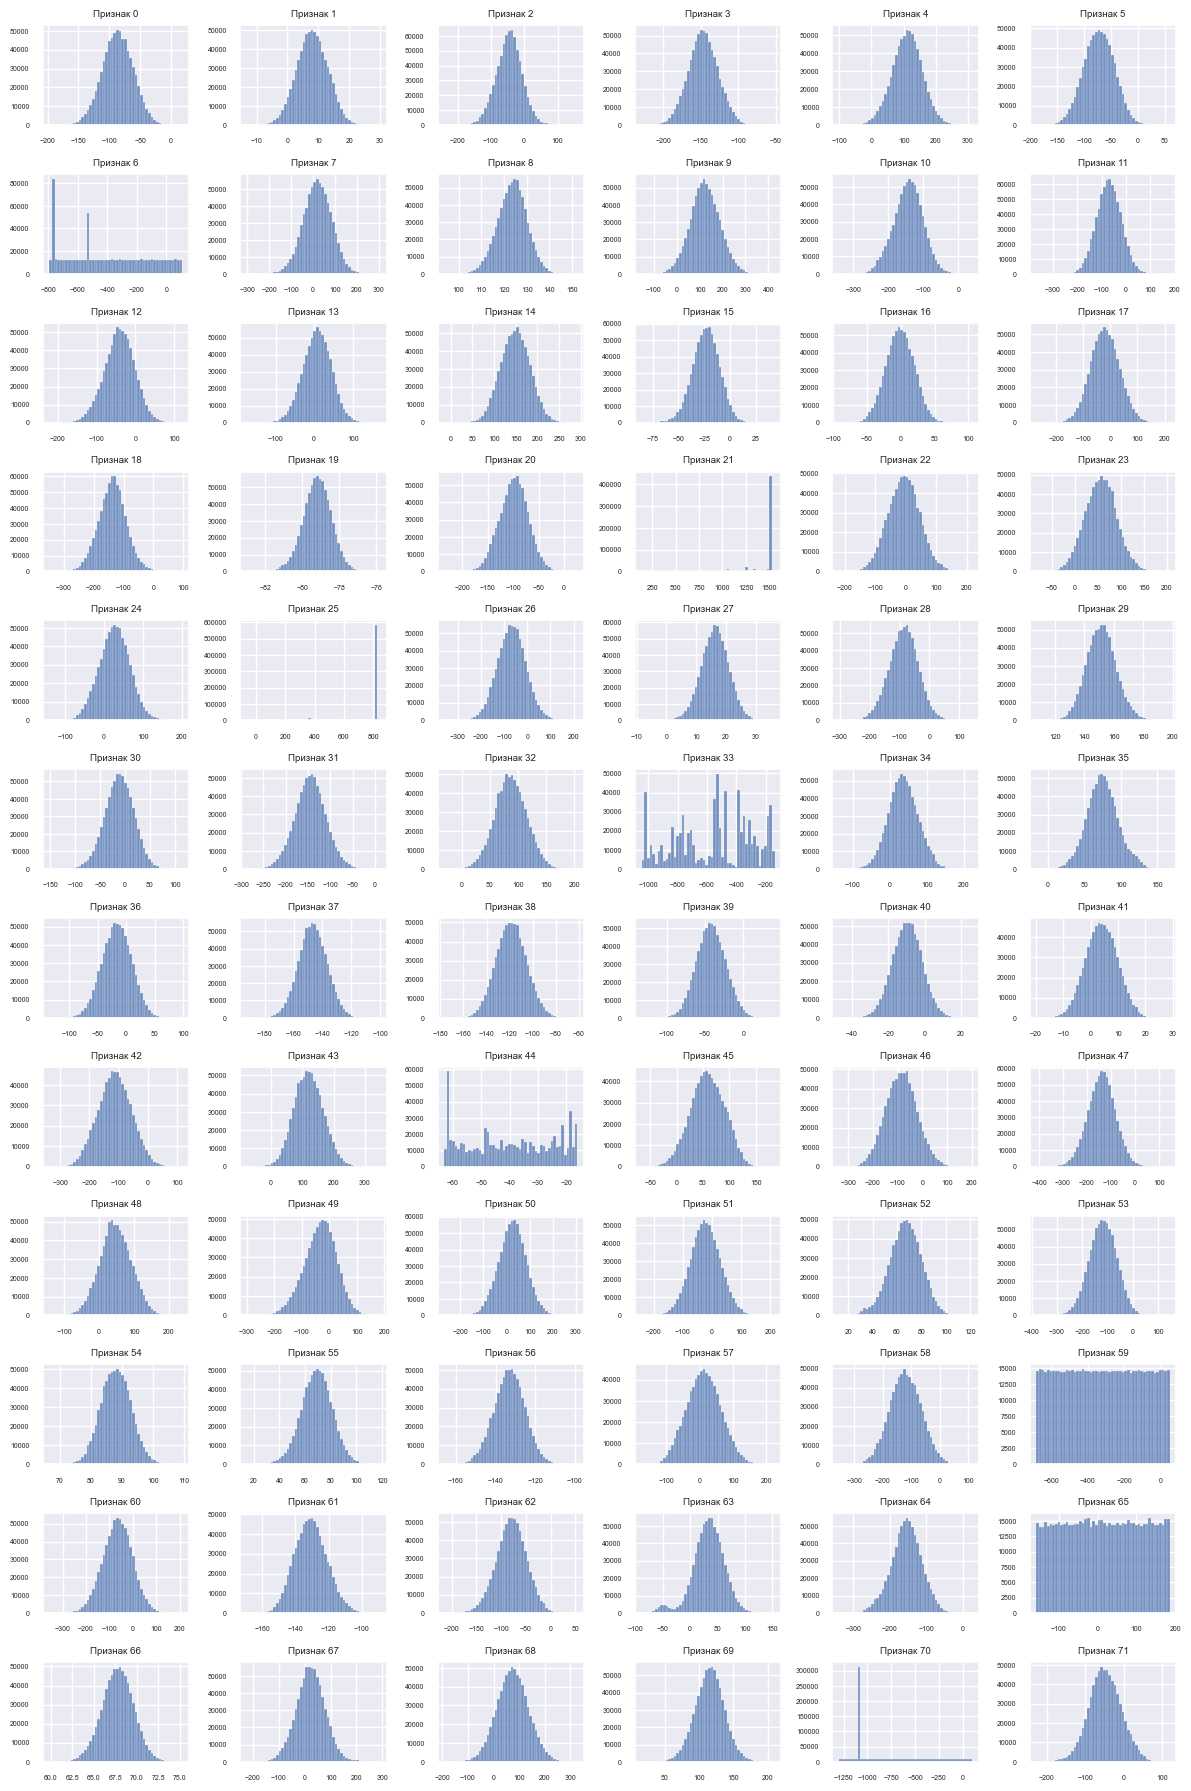

In [14]:
NCOLS = 6
NROWS = int((df_base.shape[1]) / NCOLS)
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 18))
axs = axs.flatten()
for ind, column in enumerate(df_base_short.columns):
    plot = sb.histplot(data=df_base_short, x=df_base_short.iloc[:,ind], bins=50, ax=axs[ind])
    plot.axes.set_title(f'Признак {ind}',fontsize=7)
    plot.set(xlabel='', ylabel='')
    plot.tick_params(labelsize=5)
plt.tight_layout()
plt.show()

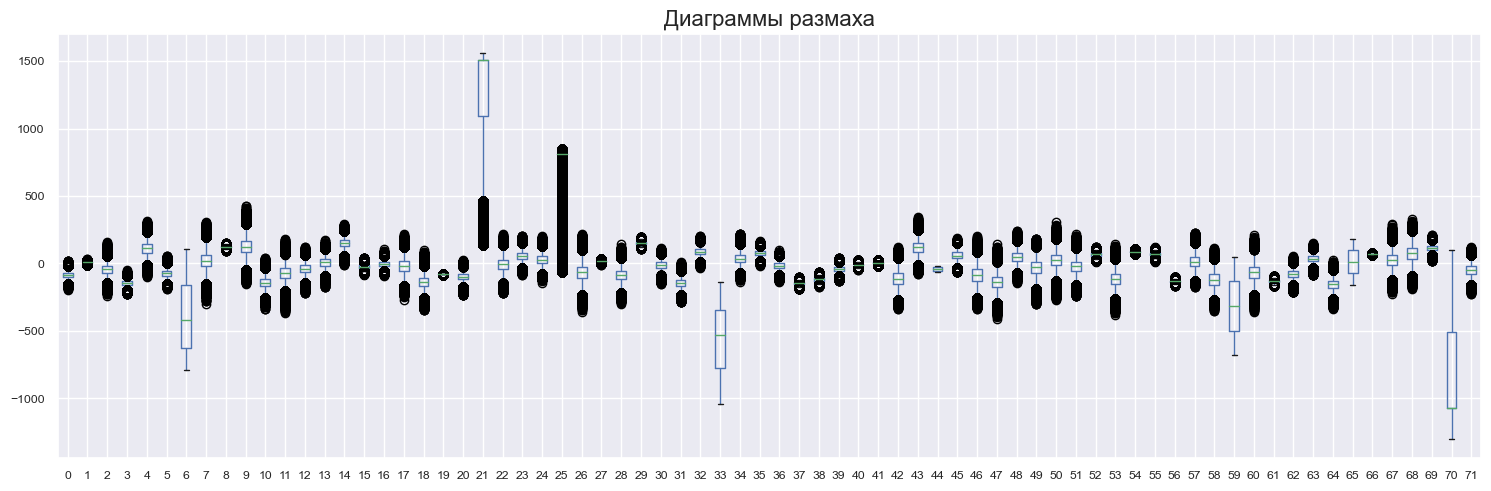

In [15]:
df_base_short.plot(kind='box', grid=True, figsize=[15, 5])
plt.title('Диаграммы размаха', fontsize=16)
plt.tight_layout()
plt.show()

### Корреляция признаков

Выведем матрицы линейной корреляции только для основного датафрейма `df_base`, т.к. остальные два являются подвыборками.

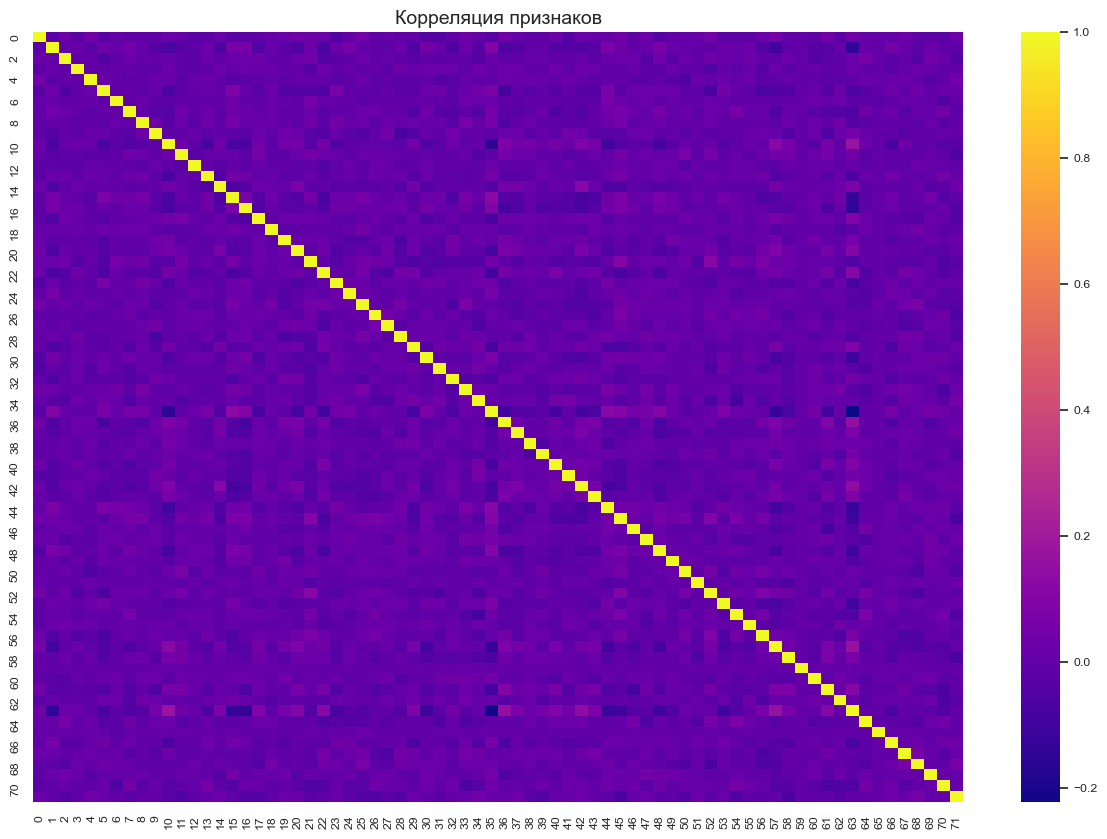

In [16]:
plt.figure(figsize=(15, 10))
sb.heatmap(df_base_short.corr(), annot=False, cmap='plasma')
plt.title('Корреляция признаков', fontsize=14)
plt.show()

### Проверка признаков на дискретность

Проверим признаки на дискретность, т.к. по графикам видны превалирующие значения в некоторых признаках.

In [17]:
unique_ratio  = (df_base_short.nunique() / df_base_short.shape[0])
print('Признаки с менее 10% уникальных значений:')
unique_ratio[unique_ratio < .1].map('{:.2%}'.format)

Признаки с менее 10% уникальных значений:


33    0.45%
44    4.05%
dtype: object

### Выводы по разделу

**Распределение признаков**:
  - Признаки имеют различный масштаб;
  - Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения приближенные к нормальному.
<br><br>

**Выбросы / аномалии**:
  - Почти во всех признаках среднее близко к медиане и присутствует минимальный процент выбросов;
  - Признаки 33 и 44 дискретны, возможно категориальны, т.к. имеют менее 10% уникальнах значений.
<br><br>

**Корреляция признаков / мультиколлинеарность**:
  - Корреляция признаков не обнаружена.

## Базовая модель

### Подготовка обучающей выборки

In [18]:
features_train = df_train.drop('Target', axis=1)
target_train = df_train['Target']
features_train.shape, target_train.shape

((100000, 72), (100000,))

### Подбор гипер-параметров FIASS

Базовая модель поиска k ближайших соседей будет построена с помощью библиотеки FAISS.

In [19]:
def get_accuracy(df_base, df_base_fraction, df_eval_features, df_eval_target,
                 faiss_n_clust = None,
                 faiss_index_type = 'ivf_flat',
                 faiss_metric = 'euclidean',
                 faiss_ef_search = 32,
                 k_similar = 5,
                 log = False):
    
    max_base_rows = int(len(df_base) * df_base_fraction)
    if max_base_rows > len(df_base):
        max_base_rows = len(df_base)
    if max_base_rows < 10:
        max_base_rows = 10
    
    # Определим базовый индекс.
    base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

    # Приведём данные в соответстие faiss.
    df_base_arr = np.ascontiguousarray(df_base.values).astype('float32')
    df_eval_arr = np.ascontiguousarray(df_eval_features.values).astype('float32')

    # Определим длину вектора признаков.
    dims = df_base.shape[1]

    # Определим квантизатор.
    quantizer = faiss.IndexFlatL2(dims)

    # Определим FAISS метрику по умолчанию
    faiss_index_metric = faiss.METRIC_L2 

    if faiss_metric == 'euclidean':
        faiss_index_metric = faiss.METRIC_L2
    elif faiss_metric == 'mahalanobis':
        # Вычислим матрицу ковариации.
        df_c = df_base - df_base.mean(0)
        cov = np.dot(df_c.T, df_c) / df_c.shape[0]

        # Преобразуем ковариационную матрицу.
        L = np.linalg.cholesky(cov)
        mahalanobis_transform = np.linalg.inv(L)

        # Функция преобразования данных.
        def inverse_cholesky_cov(df, mahalanobis_transform):
            df_trans = np.dot(df, mahalanobis_transform.T)
            return df_trans.astype('float32')

        # Преобразуем данные.
        df_base_arr = inverse_cholesky_cov(df_base, mahalanobis_transform)
        df_eval_arr = inverse_cholesky_cov(df_eval_features, mahalanobis_transform)

        faiss_index_metric = faiss.METRIC_L2
    elif faiss_metric == 'cosine':
        # Нормализуем векторы.
        faiss.normalize_L2(df_base_arr)
        faiss.normalize_L2(df_eval_arr)
        
        faiss_index_metric = faiss.METRIC_INNER_PRODUCT
    elif faiss_metric == 'mips':
        faiss_index_metric = faiss.METRIC_INNER_PRODUCT
    else:
        raise Exception(f"Unkown faiss_metric: {faiss_metric}")

    # Индекс FAISS
    if faiss_index_type == 'ivf_hnsw':
        faiss_index = faiss.index_factory(dims,(f'IVF{faiss_n_clust}_HNSW'+f'{faiss_ef_search}'+',Flat'))
        faiss_index.nprobe = 8
    elif faiss_index_type == 'ivf_flat':
        faiss_index = faiss.IndexIVFFlat(quantizer, dims, faiss_n_clust, faiss_index_metric)
    else:
        raise Exception(f"Unkown faiss_index_type: {faiss_index_type}")
    
    faiss_index.train(df_base_arr[:max_base_rows, :])
    faiss_index.add(df_base_arr[:max_base_rows, :])

    # Таблица ответов на валидирущей выборке
    start_time = perf_counter()
    vecs, idx = faiss_index.search(df_eval_arr, k_similar)
    end_time = perf_counter() - start_time
    
    # Расчет метрики accuracy@5
    acc_faiss = 0
    for t, el in zip(df_eval_target.values.tolist(), idx):
        acc_faiss += int(t in [base_index[r] for r in el])

    if log:
        print('index len:',max_base_rows)
        print('faiss_n_clust:',faiss_n_clust)
        print('faiss_metric:',faiss_metric)
        print('faiss_index_metric:',faiss_index_metric)
        print('faiss_index_type:',faiss_index_type)
        print('faiss_ef_search:',faiss_ef_search)
        print('k_similar:',k_similar)

    return round((100 * acc_faiss / len(idx)), 5), round(end_time,5)

In [20]:
results = []
for n_clusters in range(50, 200, 50):
    for metric in ['euclidean','mahalanobis']:
        for index in ['ivf_flat','ivf_hnsw']:
            accuracy, time_spent = get_accuracy(df_base=df_base_short, 
                                                  df_base_fraction=1.0,
                                                  df_eval_features=features_train,
                                                  df_eval_target=target_train,
                                                  faiss_n_clust=n_clusters,
                                                  faiss_metric=metric,
                                                  faiss_index_type=index)
            results.append({
                'Accuracy@5': accuracy,
                'Число кластеров': n_clusters,
                'Метрика': metric,
                'Индеск': index,
                'Время поиска, сек': time_spent
            })

pd.DataFrame(results).sort_values(by='Accuracy@5', ascending=False)

,Accuracy@5,Число кластеров,Метрика,Индеск,Время поиска
3,17.73,50,mahalanobis,ivf_hnsw,166.62
7,17.71,100,mahalanobis,ivf_hnsw,89.61
11,17.66,150,mahalanobis,ivf_hnsw,54.89
6,15.12,100,mahalanobis,ivf_flat,11.11
10,14.97,150,mahalanobis,ivf_flat,7.51
2,14.79,50,mahalanobis,ivf_flat,20.79
1,3.88,50,euclidean,ivf_hnsw,151.60
5,3.76,100,euclidean,ivf_hnsw,71.55
9,3.69,150,euclidean,ivf_hnsw,53.65
0,2.38,50,euclidean,ivf_flat,17.48


Оптимальные параметры, которые обеспечивают высокую метрику при не самом высоком времени исполнения:

In [21]:
opt_metric   = 'mahalanobis'
opt_index    = 'ivf_hnsw'
opt_clusters = 100

In [22]:
base_accuracy, base_time_spent = get_accuracy(df_base=df_base_short,
                                              df_base_fraction=1.0,
                                              df_eval_features=features_train,
                                              df_eval_target=target_train,
                                              faiss_n_clust=n_clusters,
                                              faiss_metric=metric,
                                              faiss_index_type=index)
base_accuracy, base_time_spent

(17.661, 71.23712)

### Выводы по разделу

* Подготовлена базовая модель на основе библиотеки FAISS;
* На сокращенной базе продуктов проведен расчет метрики accuracy@5 при различных гипер-параметрах модели;
* В качестве оптимальных гипер-параметрах по соотношению `целевая метрика / затраченное время` выбраны: 
    * Индекс: ivf-hnsw;
    * Количество кластеров: 100;
    * Мера расстояния между векторами: Расстояние Махаланобиса;
* Таблица результатов вычислений:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe" style="margin-left:40px">
  <thead>
    <tr style="text-align: right;">
      <th>Accuracy@5</th>
      <th>Число кластеров</th>
      <th>Метрика</th>
      <th>Индеск</th>
      <th>Время поиска, сек</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>17.73</td>
      <td>50</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>166.62</td>
    </tr>
    <tr>
      <td>17.71</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>89.61</td>
    </tr>
    <tr>
      <td>17.66</td>
      <td>150</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>54.89</td>
    </tr>
    <tr>
      <td>15.12</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_flat</td>
      <td>11.11</td>
    </tr>
    <tr>
      <td>14.97</td>
      <td>150</td>
      <td>mahalanobis</td>
      <td>ivf_flat</td>
      <td>7.51</td>
    </tr>
    <tr>
      <td>14.79</td>
      <td>50</td>
      <td>mahalanobis</td>
      <td>ivf_flat</td>
      <td>20.79</td>
    </tr>
    <tr>
      <td>3.88</td>
      <td>50</td>
      <td>euclidean</td>
      <td>ivf_hnsw</td>
      <td>151.60</td>
    </tr>
    <tr>
      <td>3.76</td>
      <td>100</td>
      <td>euclidean</td>
      <td>ivf_hnsw</td>
      <td>71.55</td>
    </tr>
    <tr>
      <td>3.69</td>
      <td>150</td>
      <td>euclidean</td>
      <td>ivf_hnsw</td>
      <td>53.65</td>
    </tr>
    <tr>
      <td>2.38</td>
      <td>50</td>
      <td>euclidean</td>
      <td>ivf_flat</td>
      <td>17.48</td>
    </tr>
    <tr>
      <td>1.98</td>
      <td>100</td>
      <td>euclidean</td>
      <td>ivf_flat</td>
      <td>9.83</td>
    </tr>
    <tr>
      <td>1.88</td>
      <td>150</td>
      <td>euclidean</td>
      <td>ivf_flat</td>
      <td>6.72</td>
    </tr>
  </tbody>
</table>
</div>

## Влияние признаков с ненормальным распределением

Признаки с ненормальным распределением:

In [23]:
non_normal_distribution_features = ['6', '21', '25', '33', '44', '59', '65', '70']

In [24]:
results = []
for col in non_normal_distribution_features:
    df_base_t = df_base_short.drop(col, axis=1)
    features_train_t = features_train.drop(col, axis=1)

    accuracy, time_spent = get_accuracy(df_base=df_base_t, 
                                          df_base_fraction=1.0,
                                          df_eval_features=features_train_t,
                                          df_eval_target=target_train,
                                          faiss_n_clust=opt_clusters,
                                          faiss_metric=opt_metric,
                                          faiss_index_type=opt_index)
    results.append({
        'Удаляемый признак': col,
        'Accuracy@5': accuracy,
        'Изменение': accuracy - base_accuracy,
        'Число кластеров': opt_clusters,
        'Метрика': opt_metric,
        'Индеск': opt_index,
        'Время поиска': time_spent
    })

pd.DataFrame(results)

,Удаляемый признак,Accuracy@5,Изменение,Число кластеров,Метрика,Индеск,Время поиска
0,6,17.63,-0.03,100,mahalanobis,ivf_hnsw,80.33
1,21,17.90,0.24,100,mahalanobis,ivf_hnsw,73.03
2,25,18.07,0.41,100,mahalanobis,ivf_hnsw,74.79
3,33,18.10,0.44,100,mahalanobis,ivf_hnsw,67.57
4,44,17.73,0.07,100,mahalanobis,ivf_hnsw,68.01
5,59,17.87,0.21,100,mahalanobis,ivf_hnsw,67.24
6,65,17.84,0.17,100,mahalanobis,ivf_hnsw,64.11
7,70,17.60,-0.06,100,mahalanobis,ivf_hnsw,65.70


* Признаки `6`, `70` необходимо попытаться сохранить, т.к. при их удалении целевая метрика сильно снижается и обработка признаков с ненормальным распределением без понимания их происхождения представляется проблематичной.

* Остальные признаки с ненормальным распределением, ухудшающие или не влияющие на целевую метрику, удалим.

In [25]:
col_to_clear = ['21','25','33','44','59','65']
df_base_clear = df_base_short.drop(col_to_clear, axis=1)
features_train_clear = features_train.drop(col_to_clear, axis=1)

In [26]:
base_clear_accuracy, base_clear_time_spent = get_accuracy(df_base=df_base_clear, 
                                                          df_base_fraction=1.0,
                                                          df_eval_features=features_train_clear,
                                                          df_eval_target=target_train,
                                                          faiss_n_clust=opt_clusters,
                                                          faiss_metric=opt_metric,
                                                          faiss_index_type=opt_index)

base_clear_accuracy, base_clear_time_spent

(18.941, 66.00452)

In [36]:
print ('Изменение accuracy@5:', base_clear_accuracy - base_accuracy)

Изменение accuracy@5: 1.2799999999999976


Переведём признаки 6 и 70 в распределение близкое к нормальному. Распределение значений до преобразования:

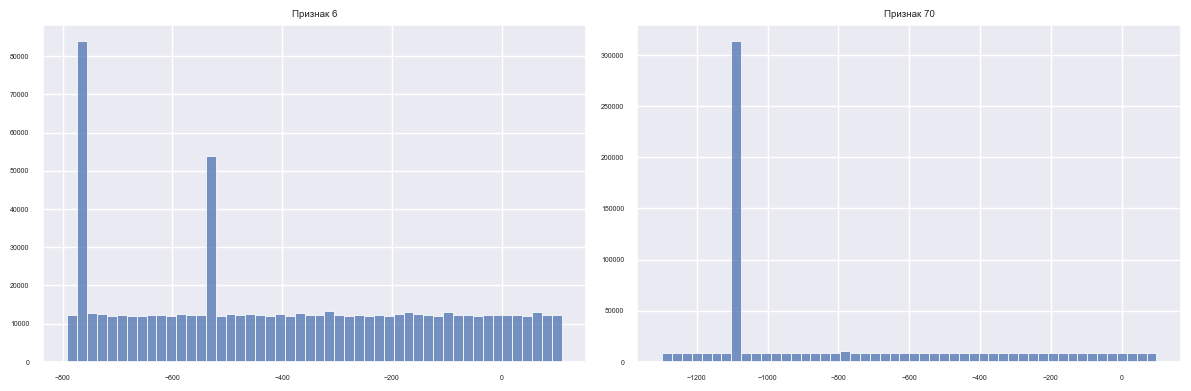

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs = axs.flatten()
for ind, column in enumerate(['6','70']):
    plot = sb.histplot(data=df_base_clear, x=df_base_clear[column], bins=50, ax=axs[ind])
    plot.axes.set_title(f'Признак {column}',fontsize=7)
    plot.set(xlabel='', ylabel='')
    plot.tick_params(labelsize=5)
plt.tight_layout()
plt.show()

In [31]:
df_base_clear_qt = df_base_clear.copy()
features_train_clear_qt = features_train_clear.copy()

cols_qt = ['6', '70']
qt = QuantileTransformer(n_quantiles=10000, 
                         output_distribution='normal', 
                         random_state=42)

df_base_clear_qt[cols_qt] = pd.DataFrame(qt.fit_transform(df_base_clear_qt[cols_qt]), 
                                         columns=cols_qt, index=df_base_clear_qt.index)

features_train_clear_qt[cols_qt] = pd.DataFrame(qt.transform(features_train_clear_qt[cols_qt]), 
                                                columns=cols_qt, index=features_train_clear_qt.index)

Распределение значений после преобразования:

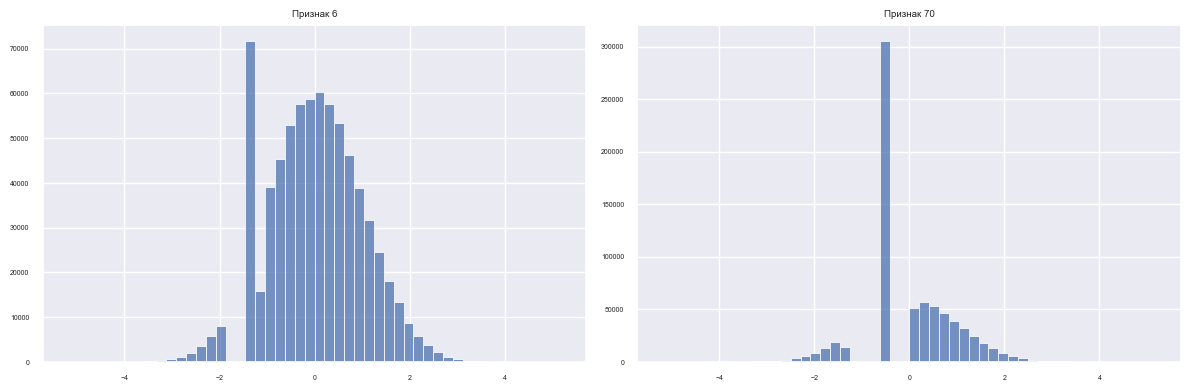

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs = axs.flatten()
for ind, column in enumerate(['6','70']):
    plot = sb.histplot(data=df_base_clear_qt, x=df_base_clear_qt[column], bins=50, ax=axs[ind])
    plot.axes.set_title(f'Признак {column}',fontsize=7)
    plot.set(xlabel='', ylabel='')
    plot.tick_params(labelsize=5)
plt.tight_layout()
plt.show()

In [33]:

base_clear_qt_accuracy, base_clear_qt_time_spent = get_accuracy(df_base=df_base_clear_qt, 
                                                                df_base_fraction=1.0,
                                                                df_eval_features=features_train_clear_qt,
                                                                df_eval_target=target_train,
                                                                faiss_n_clust=opt_clusters,
                                                                faiss_metric=opt_metric,
                                                                faiss_index_type=opt_index)

base_clear_qt_accuracy, base_clear_qt_time_spent

(18.941, 76.48972)

In [37]:
print ('Изменение accuracy@5:', base_clear_qt_accuracy - base_clear_accuracy)

Изменение accuracy@5: 0.0


Преобразование распределения признаков `6` и `70` в близкое к нормальному никак не отразилось на изменении целевой метрики.

### Выводы по разделу

* Признаки с ненормальным распределением `21`, `25`, `33`, `44`, `59`, `65`  удалены, т.к. ухудшают или не влияют на целевую метрику.
* Признаки с ненормальным распределением `6`, `70` сохранены, т.к. при их удалении целевая метрика снижается;
* Преобразование распределения признаков `6` и `70` в близкое к нормальному никак не отразилось на изменении целевой метрики.

## Масштабирование признаков

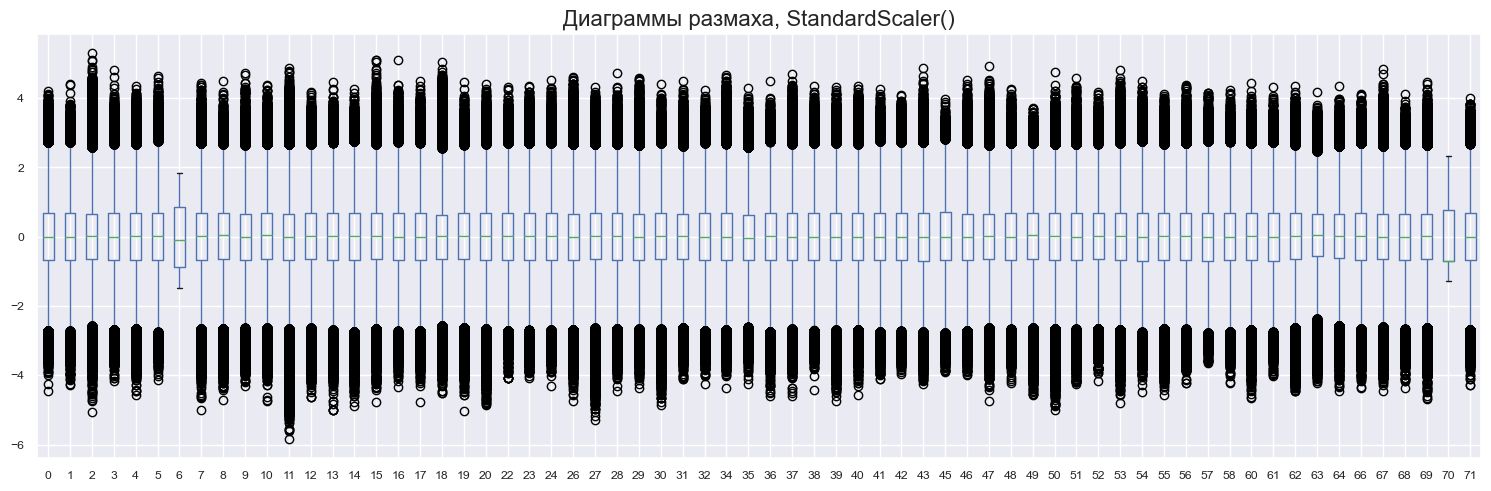

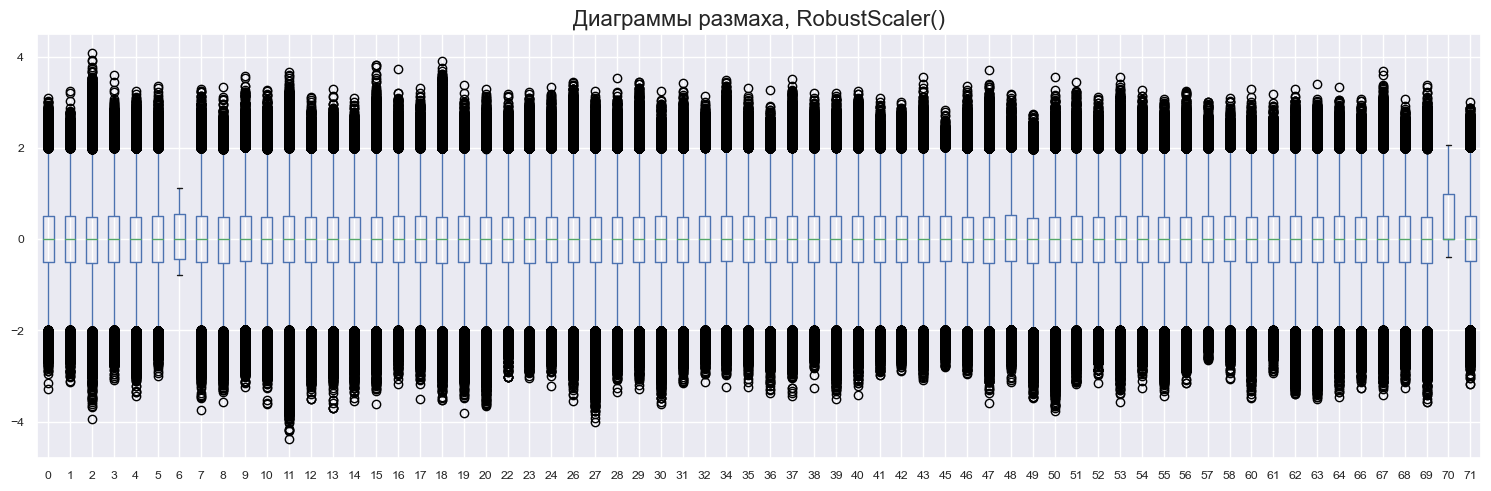

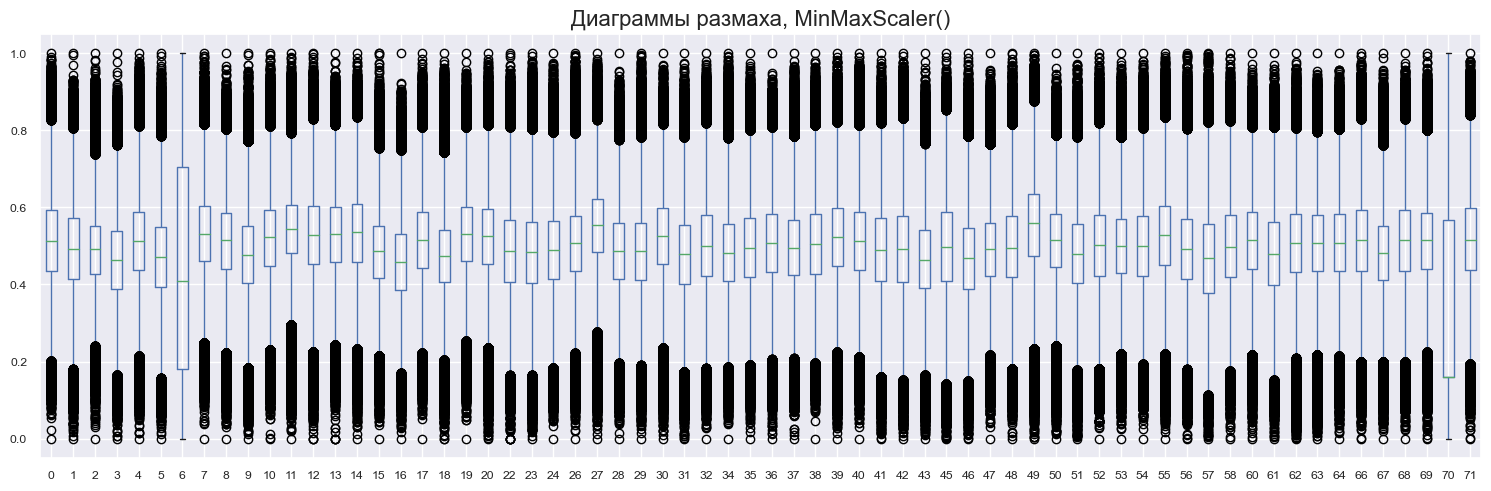

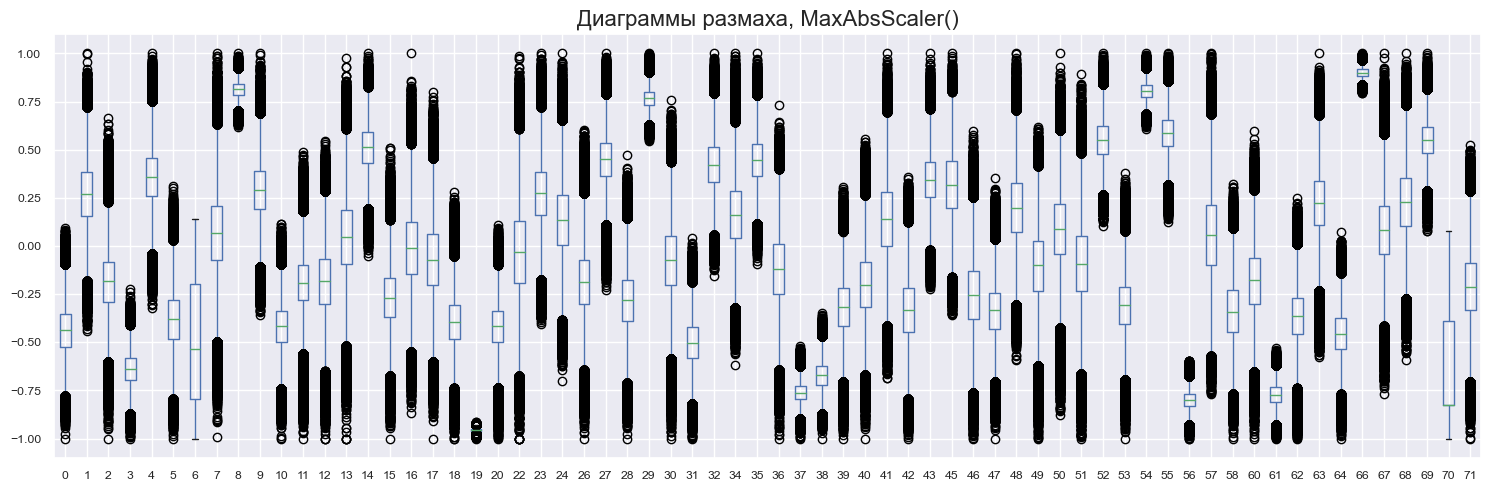

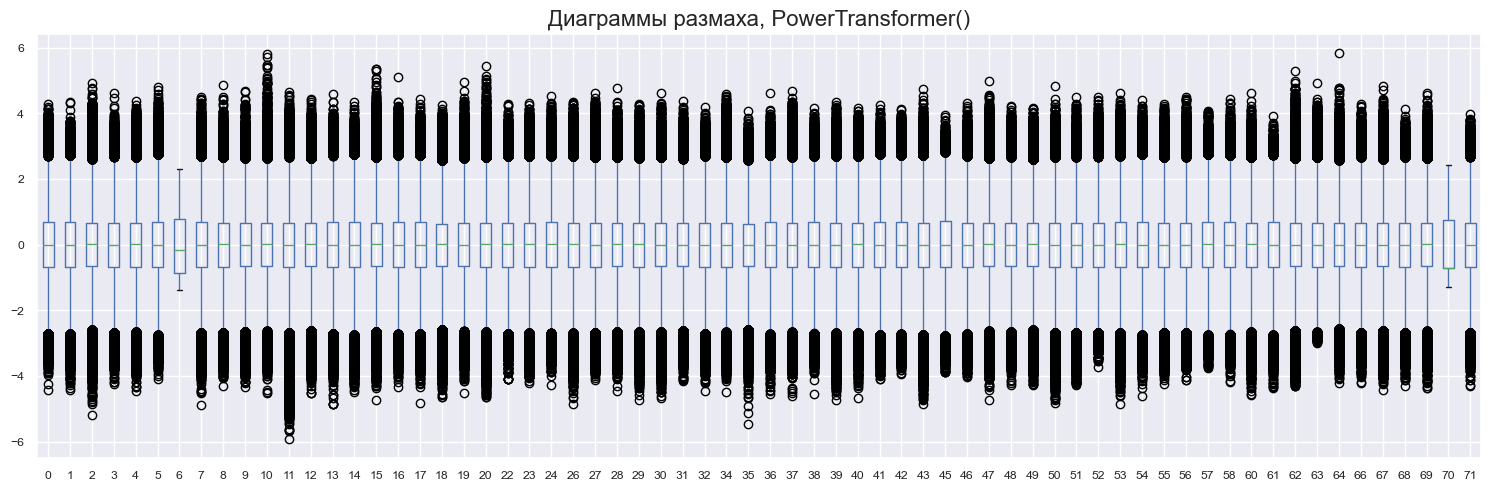

,Scaler,Accuracy@5,Изменение,Число кластеров,Метрика,Индеск,Время поиска
0,StandardScaler(),18.95,0.01,100,mahalanobis,ivf_hnsw,78.25
1,RobustScaler(),18.95,0.01,100,mahalanobis,ivf_hnsw,69.04
2,MinMaxScaler(),18.95,0.01,100,mahalanobis,ivf_hnsw,69.72
3,MaxAbsScaler(),18.94,0.00,100,mahalanobis,ivf_hnsw,68.99
4,PowerTransformer(),18.93,-0.01,100,mahalanobis,ivf_hnsw,68.25


In [38]:
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), MaxAbsScaler(), PowerTransformer()]
results = []

for scaler in scalers:
    df_base_scaled = pd.DataFrame(scaler.fit_transform(df_base_clear),
                                  columns=df_base_clear.columns,
                                  index=df_base_clear.index)
    df_train_scaled = pd.DataFrame(scaler.transform(features_train_clear),
                                   columns=features_train_clear.columns,
                                   index=features_train_clear.index)
    
    df_base_scaled.plot(kind='box', grid=True, figsize=[15, 5])
    plt.title(f'Диаграммы размаха, {scaler}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    accuracy, time_spent = get_accuracy(df_base=df_base_scaled, 
                                          df_base_fraction=1.0,
                                          df_eval_features=df_train_scaled,
                                          df_eval_target=target_train,
                                          faiss_n_clust=opt_clusters,
                                          faiss_metric=opt_metric,
                                          faiss_index_type=opt_index)
    
    results.append({
        'Scaler': scaler,
        'Accuracy@5': accuracy,
        'Изменение': accuracy - base_clear_accuracy,
        'Число кластеров': opt_clusters,
        'Метрика': opt_metric,
        'Индеск': opt_index,
        'Время поиска': time_spent
    })

pd.DataFrame(results)

### Выводы по разделу

* Произведен расчет целевой метрики после масштабирования признаков с помощью различных механимов;
* Применение `StandardScaler`, `RobustScaler` и `MinMaxScaler` незначительно улучшило целевую метрику. `RobustScaler` при этом показал меньшее время поиска и будет использоваться в финальной модели; 
* Таблица результатов вычислений:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe" style="margin-left:40px">
  <thead>
    <tr style="text-align: right;">
      <th>Scaler</th>
      <th>Accuracy@5</th>
      <th>Изменение</th>
      <th>Число кластеров</th>
      <th>Метрика</th>
      <th>Индеск</th>
      <th>Время поиска, сек</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>StandardScaler()</td>
      <td>18.95</td>
      <td>0.01</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>78.25</td>
    </tr>
    <tr>
      <td>RobustScaler()</td>
      <td>18.95</td>
      <td>0.01</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>69.04</td>
    </tr>
    <tr>
      <td>MinMaxScaler()</td>
      <td>18.95</td>
      <td>0.01</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>69.72</td>
    </tr>
    <tr>
      <td>MaxAbsScaler()</td>
      <td>18.94</td>
      <td>0.00</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>68.99</td>
    </tr>
    <tr>
      <td>PowerTransformer()</td>
      <td>18.93</td>
      <td>-0.01</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>68.25</td>
    </tr>
  </tbody>
</table>
</div>

## Тестирование модели

Для тестирования используется следующая модель: 
* Библиотека `FAISS`;
    * Индекс: ivf-hnsw;
    * Количество кластеров: 100;
    * Мера расстояния между векторами: Расстояние Махаланобиса;
* Признаки с ненормальным распределением `21`, `25`, `33`, `44`, `59`, `65` не используются;
* К остальным признакам применено масштабирование `RobustScaler`.

In [39]:
df_base_clear = df_base.drop(col_to_clear, axis=1)
df_test_clear = df_test.drop(col_to_clear, axis=1)

In [40]:
scaler = RobustScaler()

if scaler == None:
    df_base_scaled = df_base_clear
    df_test_scaled = df_test_clear
else:
    df_base_scaled = pd.DataFrame(scaler.fit_transform(df_base_clear),
                                  columns=df_base_clear.columns,
                                  index=df_base_clear.index)
    df_test_scaled = pd.DataFrame(scaler.transform(df_test_clear),
                                  columns=df_test_clear.columns,
                                  index=df_test_clear.index)

In [41]:
get_accuracy(df_base=df_base_scaled, 
             df_base_fraction=1,
             df_eval_features=df_test_scaled,
             df_eval_target=df_answer['Expected'],
             faiss_n_clust=opt_clusters,
             faiss_metric=opt_metric,
             faiss_index_type=opt_index)

(70.852, 402.31599)

### Выводы по разделу

Целевая метрика accuracy@5 на тестовой выбоке: `70.852%`

## Общий вывод

#### 1. Выполнена загрузка датасетов
* Размер датасетов:
  - `df_base`: 2918139 x 72 с идентификаторами объектов в индексе;
  - `df_train`: 100000 x 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `df_test`: 100000 x 72 с идентификаторами объектов в индексе;
  - `df_answer`: 100000 x 1 - признак ответов с идентификаторами объектов в индексе.
* Пропуски и дубликаты:
  - Данные не имеют пропусков и дубликатов за исключением дубликатов списка ответов валидационной выборки `df_answer`, которые означают, что одному товару могут соответствовать несколько.

#### 2. Выполнен исследовательский анализ

* Признаки имеют различный масштаб;
* Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения приближенные к нормальному.
* Почти во всех признаках среднее близко к медиане и присутствует минимальный процент выбросов;
* Признаки 33 и 44 дискретны, возможно категориальны, т.к. имеют менее 10% уникальнах значений.
* Корреляция признаков не обнаружена.

#### 3. Подготовлена базовая модель

* Подготовлена базовая модель на основе библиотеки FAISS;
* На сокращенной базе продуктов проведен расчет метрики accuracy@5 при различных гипер-параметрах модели;
* В качестве оптимальных гипер-параметрах по соотношению `целевая метрика / затраченное время` выбраны: 
    * Индекс: ivf-hnsw;
    * Количество кластеров: 100;
    * Мера расстояния между векторами: Расстояние Махаланобиса;
* Таблица результатов вычислений:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe" style="margin-left:40px">
  <thead>
    <tr style="text-align: right;">
      <th>Accuracy@5</th>
      <th>Число кластеров</th>
      <th>Метрика</th>
      <th>Индеск</th>
      <th>Время поиска, сек</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>17.73</td>
      <td>50</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>166.62</td>
    </tr>
    <tr>
      <td>17.71</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>89.61</td>
    </tr>
    <tr>
      <td>17.66</td>
      <td>150</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>54.89</td>
    </tr>
    <tr>
      <td>15.12</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_flat</td>
      <td>11.11</td>
    </tr>
    <tr>
      <td>14.97</td>
      <td>150</td>
      <td>mahalanobis</td>
      <td>ivf_flat</td>
      <td>7.51</td>
    </tr>
    <tr>
      <td>14.79</td>
      <td>50</td>
      <td>mahalanobis</td>
      <td>ivf_flat</td>
      <td>20.79</td>
    </tr>
    <tr>
      <td>3.88</td>
      <td>50</td>
      <td>euclidean</td>
      <td>ivf_hnsw</td>
      <td>151.60</td>
    </tr>
    <tr>
      <td>3.76</td>
      <td>100</td>
      <td>euclidean</td>
      <td>ivf_hnsw</td>
      <td>71.55</td>
    </tr>
    <tr>
      <td>3.69</td>
      <td>150</td>
      <td>euclidean</td>
      <td>ivf_hnsw</td>
      <td>53.65</td>
    </tr>
    <tr>
      <td>2.38</td>
      <td>50</td>
      <td>euclidean</td>
      <td>ivf_flat</td>
      <td>17.48</td>
    </tr>
    <tr>
      <td>1.98</td>
      <td>100</td>
      <td>euclidean</td>
      <td>ivf_flat</td>
      <td>9.83</td>
    </tr>
    <tr>
      <td>1.88</td>
      <td>150</td>
      <td>euclidean</td>
      <td>ivf_flat</td>
      <td>6.72</td>
    </tr>
  </tbody>
</table>
</div>

#### 4. Исследовано влияние признаков с ненормальным распределением

* Признаки с ненормальным распределением `21`, `25`, `33`, `44`, `59`, `65`  удалены, т.к. ухудшают или не влияют на целевую метрику.
* Признаки с ненормальным распределением `6`, `70` сохранены, т.к. при их удалении целевая метрика снижается;
* Преобразование распределения признаков `6` и `70` в близкое к нормальному никак не отразилось на изменении целевой метрики.

#### 5. Исследовано влияние масштабирования признаков

* Произведен расчет целевой метрики после масштабирования признаков с помощью различных механимов;
* Применение `StandardScaler`, `RobustScaler` и `MinMaxScaler` незначительно улучшило целевую метрику. `RobustScaler` при этом показал меньшее время поиска и будет использоваться в финальной модели; 
* Таблица результатов вычислений:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe" style="margin-left:40px">
  <thead>
    <tr style="text-align: right;">
      <th>Scaler</th>
      <th>Accuracy@5</th>
      <th>Изменение</th>
      <th>Число кластеров</th>
      <th>Метрика</th>
      <th>Индеск</th>
      <th>Время поиска, сек</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>StandardScaler()</td>
      <td>18.95</td>
      <td>0.01</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>78.25</td>
    </tr>
    <tr>
      <td>RobustScaler()</td>
      <td>18.95</td>
      <td>0.01</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>69.04</td>
    </tr>
    <tr>
      <td>MinMaxScaler()</td>
      <td>18.95</td>
      <td>0.01</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>69.72</td>
    </tr>
    <tr>
      <td>MaxAbsScaler()</td>
      <td>18.94</td>
      <td>0.00</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>68.99</td>
    </tr>
    <tr>
      <td>PowerTransformer()</td>
      <td>18.93</td>
      <td>-0.01</td>
      <td>100</td>
      <td>mahalanobis</td>
      <td>ivf_hnsw</td>
      <td>68.25</td>
    </tr>
  </tbody>
</table>
</div>

#### 6. Выполнено тестирование финальной модели

* Для тестирования используется следующая модель: 
    * Библиотека `FAISS`;
    * Индекс: ivf-hnsw;
    * Количество кластеров: 100;
    * Мера расстояния между векторами: Расстояние Махаланобиса;
    * Признаки с ненормальным распределением `21`, `25`, `33`, `44`, `59`, `65` не используются;
    * К остальным признакам применено масштабирование `RobustScaler`.

* Целевая метрика accuracy@5 на тестовой выбоке: `70.852%`.

#### 7. Возможные направления улучшения целевой метрики:
* Проведение более развёрнутого анализа кластеров / признаков;
* Использование других библиотек, например `ANNOY`;
* Использование других алгоритмов, например `KMeans` + `NearestNeigbors`.